In [1]:
import requests
from bs4 import BeautifulSoup
from fake_useragent import UserAgent
from lxml import html
import logging
import pandas as pd
import time
import os
import utils

In [2]:
logging.basicConfig(
    format='%(asctime)s %(levelname)-8s %(message)s',
    level=logging.INFO,
    datefmt='%Y-%m-%d %H:%M:%S'
)

In [3]:
URL = 'https://auction.ru/listing/offer/drugoe_v_iskusstvo_i_antikvariat-48267'
HEADERS = {'user-agent': UserAgent().random}
HOST = 'https://auction.ru'
PATH = 'C:/Devs/Antikvar/images/'

--------------------

## Parser 🧙‍

In [4]:
def get_html(url:str) -> requests:
    r = requests.get(url, headers=HEADERS, params=None)
    return r

In [10]:
def get_urls(html: str, base:pd.DataFrame):
    soup = BeautifulSoup(html, 'html.parser')
    items = soup.find_all('a', class_='offers__item__title')
    #print(items)
    urlitems = [HOST + i.attrs['href'] for i in items]

    allurlimg = []
    
    new_line_count = 0
    for urlitem in urlitems:
        temp = []
        html = get_html(urlitem)
        soup = BeautifulSoup(html.text, 'html.parser')
        item = soup.find('div', class_='fotorama')
        item = item.find_all('a')
        for i in item:
            temp.append(i['href'])
            new_line_count += 1
        allurlimg.append(temp)
    
    num = 0
       
    new_line_flag = 0
    try:
        start_idx=base["id"].iloc[-1]
    except IndexError:
        start_idx=0
        
    for idx, item in enumerate(allurlimg, start=start_idx):
        for picture in item:
            temp_name = picture.replace("/", "_").replace(":", "_").replace(".", "_")
            if temp_name not in base["image"].to_list():
                img = requests.get(picture)
                with open(PATH + picture.replace("/", "_").replace(":", "_").replace(".", "_") + ".jpg", "wb") as f:
                    f.write(img.content)
                base = base.append({"id":idx, "image":temp_name, "url": picture}, ignore_index=True)
                num += 1
                
    return num, base

In [11]:
def parse_action(base):
    html = get_html(URL)
    if html.status_code == 200:
        num, base = get_urls(html.text, base)
        logging.info(f"Parse of {num} complite")
    else:
        logging.error(html.status_code)
    return base

### Endless log 🥾 &minus; in script!

In [ ]:
#for start
base = pd.DataFrame(columns=["id", "image", "url"])
base.to_csv(PATH + "base.csv", header=True, index=False)

In [16]:
base = pd.read_csv(PATH + "base.csv")

In [ ]:
while True:
    base = parse_action(base).copy()
    base.to_csv(PATH + "base.csv", header=True, index=False)
    time.sleep(20)
    if len(base) >= 2000:
        break
logging.info(f"Count of images {len(base)}")

---------------------

In [4]:
from tensorflow import keras as keras
import tensorflow as tf
from keras.applications import ResNet152V2
import pandas as pd
import numpy as np
from PIL import Image
from imgaug import augmenters as iaa
from sklearn.model_selection import train_test_split
%pylab inline

Using TensorFlow backend.


Populating the interactive namespace from numpy and matplotlib


## Get dataset 😱

* Входная форма $224 \times 224 \times 3$
* Убрать:
  * $>$ 3 картинок на предмет
  * youtube 

In [5]:
base = pd.read_csv(PATH + "base.csv")

In [6]:
base = pd.read_csv(PATH + "base.csv")
info_id = base.groupby("id").count()
info_id = info_id[info_id["image"] > 2].index
base = base[base['id'].isin(info_id)]
base = base[~base["image"].str.contains("youtube")]

In [ ]:
x = []
y = []
for i in range(len(base)):
    x.append(np.array(Image.open(PATH + base.iloc[i, 1] + ".jpg").resize((224,224), Image.ANTIALIAS)))
    y.append(base.iloc[i, 0])

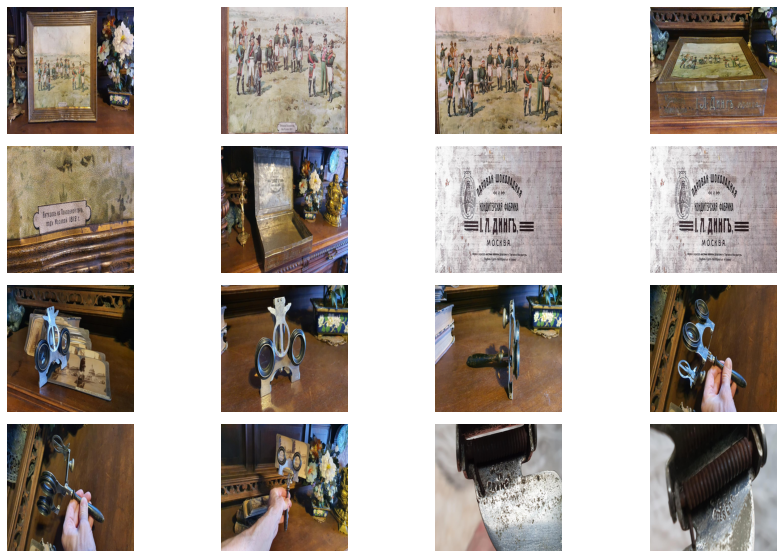

In [8]:
plt.rcParams.update({'font.size':14})
fig, ax = plt.subplots(4,4, figsize=(15,10))
for i in range(4):
    for j in range(4):
        ax[i,j].imshow(x[i*4+j])
        ax[i,j].set_axis_off()
plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.show()

# Augmentation 🐨

In [9]:
seq = iaa.Sequential([
    iaa.Affine(rotate=(-25, 25)),
    iaa.AdditiveGaussianNoise(scale=(10, 60)),
    iaa.ElasticTransformation(alpha=(0.5, 3.5), sigma=0.25),
    iaa.PiecewiseAffine(scale=(0.01, 0.05)),
    iaa.PerspectiveTransform(scale=(0.01, 0.1)),
    iaa.Crop(percent=(0, 0.2)),
    iaa.Cutout(),
    iaa.Fliplr(0.5),
    iaa.Flipud(0.2)
], random_order=True)

In [10]:
def augment_all(images:list, labels:list, seq:iaa.Sequential, scale_factor:int=10) -> tuple:
    
    logging.info("Start augmentation for {:5d} images".format(len(images)))
    y_augment = []
    x_augment = np.asarray([seq(images=images[0:1]) for _ in range(scale_factor)]).reshape((scale_factor, *images[0].shape))
    y_augment.extend([labels[0] for k in range(scale_factor)])
    for i in range(1, len(images)):
        if i == len(images) - 1:
            temp = np.asarray([seq(images=images[-1:]) for _ in range(scale_factor)]).reshape((scale_factor, *images[0].shape))
        else:
            temp = np.asarray([seq(images=images[i:i+1]) for _ in range(scale_factor)]).reshape((scale_factor, *images[0].shape))
        x_augment = np.vstack([x_augment, temp])
        y_augment.extend([labels[i] for k in range(scale_factor)])
        
    y_augment = np.asarray(y_augment)
    logging.info("Augmentation complite, new dataset: {:7d}".format(len(x_augment)))
    return x_augment, y_augment

In [11]:
x_augment, y_augment = augment_all(x, y, seq=seq, scale_factor=3)

2021-04-19 12:05:42 INFO     Start augmentation for  1836 images
2021-04-19 12:20:43 INFO     Augmentation complite, new dataset:    5508


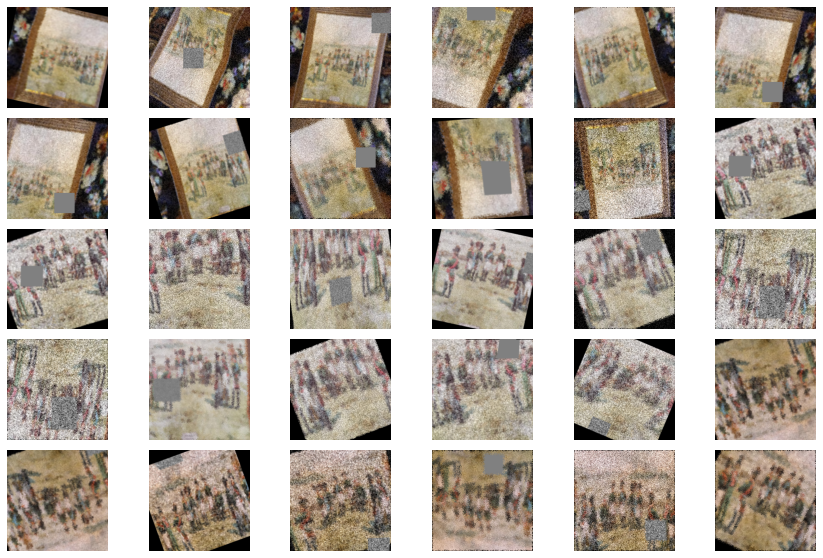

In [12]:
plt.rcParams.update({'font.size':14})
fig, ax = plt.subplots(5, 6, figsize=(15,10))
for i in range(5):
    for j in range(6):
        ax[i,j].imshow(x_augment[i*5 + j])
        ax[i,j].set_axis_off()
plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.show()

## ResNET 🏋️‍

In [7]:
resnet = keras.models.Sequential()
resnet.add(keras.applications.ResNet50V2(
    include_top=False,
    weights="imagenet",
    input_shape=(224, 224, 3),
    pooling=True,
))
resnet.add(keras.layers.AveragePooling2D(pool_size=(7,7)))
resnet.add(keras.layers.Flatten())
resnet.compile()

In [ ]:
resnet.summary()

In [ ]:
flat_x = resnet.predict(np.asarray(x_augment) / 255.)

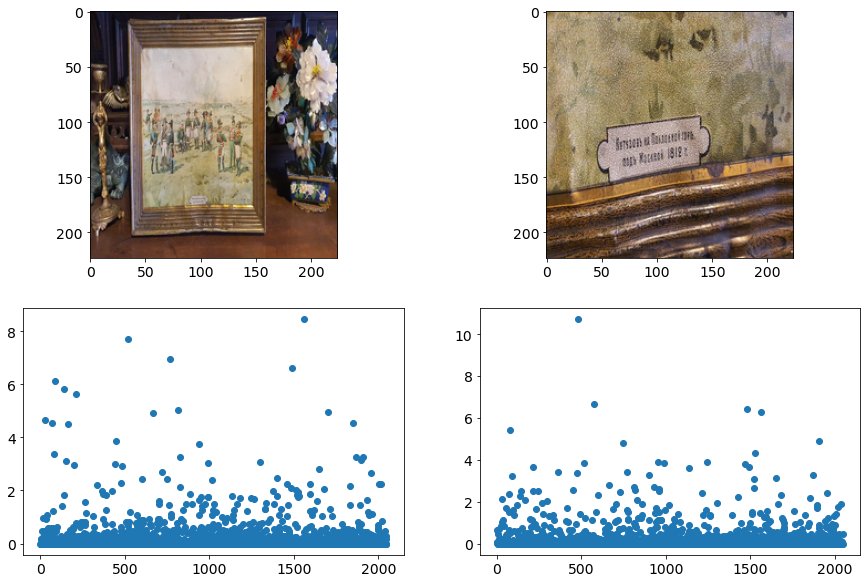

In [16]:
plt.rcParams.update({'font.size':14})
fig, ax = plt.subplots(2,2, figsize=(15,10))
ax[0,0].imshow(x[0])
ax[0,1].imshow(x[4])
ax[1,0].scatter([x for x in range(len(flat_x[0]))], flat_x[0])
ax[1,1].scatter([x for x in range(len(flat_x[4]))], flat_x[4])
plt.show()

**Form pairs** 

### rebuild this shit!!

* add left-to-right aug
* balanced
* watch to memory


In [123]:
del x_augment

In [15]:
np.save("flat_x_3.npy", flat_x)

----------------------

In [8]:
flat_x = np.load("flat_x_wo_aug.npy")

In [7]:
flat_x.shape

(1836, 2048)

In [9]:
def into_category(flat_x:np.ndarray):
    x_train = []
    for i in range(len(flat_x)):
        for j in range(len(flat_x)):
            if i != j:
                x_train.append(np.hstack([flat_x[i], flat_x[j]]))
                x_train.append(np.hstack([flat_x[j], flat_x[i]]))
    return x_train

In [10]:
def base_extends(base:pd.DataFrame, scale_factor:int=1):
    df_new = pd.DataFrame(columns=base.columns)
    for idx in range(len(base)):
        df_new = df_new.append(base.iloc[idx])
        for _ in range(scale_factor):
            df_new=df_new.append(pd.Series(), ignore_index=True, dtype=str)
    df_new = df_new.fillna(method='ffill')
    return df_new

In [11]:
def get_data(flat_x:np.ndarray, base:pd.DataFrame, scale_factor:int=1) -> tuple:
    x_train = []
    y_train = []
    
    if scale_factor >= 2:     
        base = base_extends(base, scale_factor - 1)
        
    nu = 0
    
    logging.info("Get {:10d} indexies for {:10d} items".format(len(base), len(flat_x)))
    
    for i in base["id"].unique():
        temp_x = flat_x[base[base['id'] == i].index[0]: base[base['id'] == i].index[-1]]
        temp_x = into_category(temp_x)
        
        x_train.extend(temp_x)
        y_train.extend([1 for i in range(len(temp_x))])
        if len(x_train) - nu > 100000:
            nu = len(x_train)
            logging.info("{:10d} positive pairs are calculated".format(nu))
            
    logging.info("Total number of positive pairs: {:10d}".format(len(x_train)))
    
    bound = len(x_train)
    i = 0
    bad_choise = 0
    nu_neg = 1
    while i < bound:
        idx = np.random.randint(0,len(base), 2)
        if base.iloc[idx[0], 0] == base.iloc[idx[1], 0]:
            bad_choise += 1
        else:
            x_train.append(np.hstack([flat_x[idx[0]], flat_x[idx[1]]]))
            y_train.append(0)
            nu_neg += 1
            i += 1
        if nu_neg % 100000 == 0:
            logging.info("{:10d} negative pairs are calculated, {:10d} bad choises".format(nu_neg, bad_choise))
    
    logging.info("Total number of negative pairs: {:10d}, bad choises: {:10d}".format(nu_neg - 1, bad_choise))
            
    return x_train, y_train

In [12]:
x_train, y_train = get_data(flat_x, base, scale_factor=1)

2021-04-19 18:21:18 INFO     Get       1836 indexies for       1836 items
2021-04-19 18:21:18 INFO     Total number of positive pairs:      12356
2021-04-19 18:21:19 INFO     Total number of negative pairs:      12356, bad choises:         33


In [13]:
x_train = np.asarray(x_train)
y_train = np.asarray(y_train)

In [15]:
np.save("x_train_300k.npy", x_train)
np.save("y_train_300k.npy", y_train)

# OLD! 
-------------

In [12]:
def get_data_old(base:pd.DataFrame, balanced:bool=True) -> tuple:
    x_train = []
    y_train = []
    nu = 1
    for i in range(len(flat_x)):
        current_item = base.iloc[i,0]
        for j in range(len(flat_x)):
            y = int(base.iloc[j,0] == current_item)
            x_train.append(np.hstack([flat_x[i], flat_x[j]]))
            y_train.append(y)
            if nu % 50000 == 0:
                logging.info(f"Обработано {nu} пар")
            nu += 1
    logging.info(f"Обработано {nu} пар")
    x_train = np.asarray(x_train)
    y_train = np.asarray(y_train)
    
    if balanced:
        idx = np.where(y_train == 1)[0]
        idx_false = np.random.choice(np.where(y_train == 0)[0], len(idx), replace=False)
        idx = np.append(idx, idx_false)

        x_train = x_train[idx]
        y_train = y_train[idx]

        logging.info(f"Выборка сбалансированна: {len(x_train)} пар")
    y_train = np.eye(2)[y_train]
    return x_train, y_train

In [13]:
x_train, y_train = get_data(base, balanced=False)

2021-04-16 15:39:47 INFO     Обработано 50000 пар
2021-04-16 15:39:49 INFO     Обработано 100000 пар
2021-04-16 15:39:51 INFO     Обработано 150000 пар
2021-04-16 15:39:52 INFO     Обработано 170570 пар


------------------

In [14]:
x_train = np.load("x_train_300k.npy")
y_train = np.load("y_train_300k.npy")
y_train = np.eye(2)[y_train]

In [15]:
print("Отношение классов\n{:15s}:{:6d} объектов\n{:15s}:{:6d} объектов\n{:15s}:{:.4f}\n{:15s}:{:.4f}".format(
    "Одинаковые", int(sum(y_train[:,1])), "Разные", int(len(y_train[:,1]) - sum(y_train[:,1])), "Отношение", sum(y_train[:,1]) / (len(y_train[:,1]) - sum(y_train[:,1])),
    "Обр. отношение", 1 - sum(y_train[:,1]) / (len(y_train[:,1]) - sum(y_train[:,1]))
))

Отношение классов
Одинаковые     : 12356 объектов
Разные         : 12356 объектов
Отношение      :1.0000
Обр. отношение :0.0000


### train-validation-test split

In [16]:
all_lenth = len(y_train)
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.2, random_state=42, shuffle=True)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=42, shuffle=True)

print("Выбокри для обучения:\n\t{:15s} : {:6d}, {:.0f}%\n\t{:15s} : {:6d}, {:.0f}%\n\t{:15s} : {:6d}, {:.0f}%".format(
    "Обучающая", len(x_train), len(x_train) / all_lenth * 100,
    "Валидационная", len(x_val), len(x_val) / all_lenth * 100,
    "Тестовая", len(x_test), len(x_test) / all_lenth * 100
))

Выбокри для обучения:
	Обучающая       :  17792, 72%
	Валидационная   :   1977, 8%
	Тестовая        :   4943, 20%


# Model 💆‍

In [17]:
model = keras.models.Sequential()
model.add(keras.layers.Dense(512, activation="tanh", input_shape=(2048*2,)))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(128, activation="tanh"))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(32, activation="tanh"))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(2, activation="softmax"))
opt = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss=keras.losses.CategoricalCrossentropy(), metrics=[keras.metrics.Accuracy(), keras.metrics.AUC()])

In [18]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               2097664   
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               65664     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                4128      
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                

In [19]:
%%time
history = model.fit(
    x_train,
    y_train,
    batch_size=1024,
    epochs=1000,
    validation_data=(x_val, y_val),
    verbose=0
)

Wall time: 28min 56s


In [20]:
model.save("seacher_v.02")

2021-04-19 18:50:38 WARNING  From c:\users\root\appdata\local\programs\python\python38\lib\site-packages\tensorflow\python\ops\resource_variable_ops.py:1813: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
2021-04-19 18:50:39 INFO     Assets written to: seacher_v.02\assets


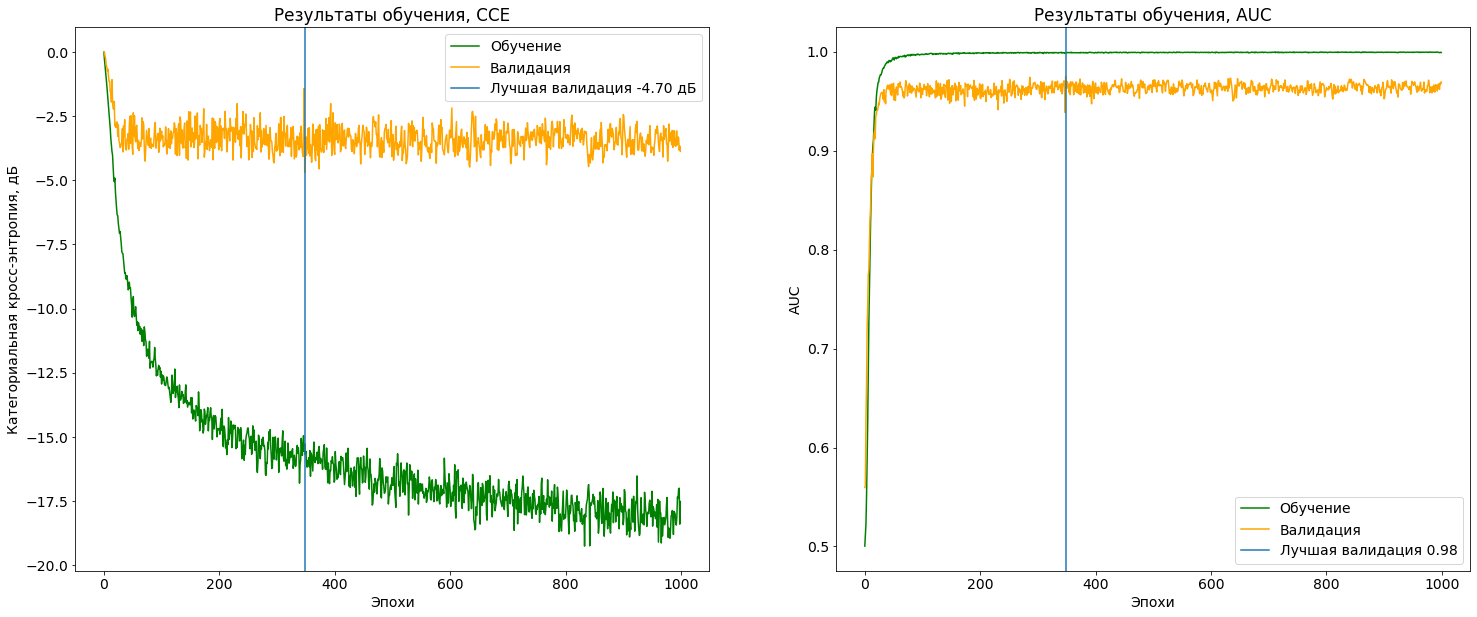

In [21]:
plt.rcParams.update({'font.size': 14})
fig, ax = plt.subplots(1, 2, figsize=(25,10))
ax[0].plot(10 * np.log10(np.array(history.history["loss"]) / history.history["loss"][0]), "g", label="Обучение")
ax[0].plot(10 * np.log10(np.array(history.history["val_loss"]) / history.history["val_loss"][0]), "orange", label="Валидация")
ax[0].axvline(np.argmin(history.history["val_loss"]), label="Лучшая валидация {:.2f} дБ".format(
    10 * np.log10(min(history.history["val_loss"]) / history.history["val_loss"][0])
))
ax[0].set_title("Результаты обучения, CCE")
ax[0].set_ylabel("Категориальная кросс-энтропия, дБ")
ax[0].set_xlabel("Эпохи")
ax[0].legend(loc="best")

ax[1].plot(history.history["auc"], "g", label="Обучение")
ax[1].plot(history.history["val_auc"], "orange", label="Валидация")
ax[1].axvline(np.argmin(history.history["val_loss"]), label="Лучшая валидация {:.2f}".format(max(history.history["val_auc"])))
#ax[1].plot([0.5 for x in range(len(history.history["loss"]))], "r--", label="Случайны классификатор")
ax[1].set_title("Результаты обучения, AUC")
ax[1].set_ylabel("AUC")
ax[1].set_xlabel("Эпохи")
ax[1].legend(loc="lower right")

plt.subplots_adjust(hspace=.3)
plt.show()

In [22]:
train_proba = model.predict_proba(x_train)
val_proba = model.predict_proba(x_val)
test_proba = model.predict_proba(x_test)

metrics_train = utils.confusion_data((y_train[:, 1].reshape((-1,1)), train_proba[:, -1].reshape((-1,1))))
metrics_valid = utils.confusion_data((y_val[:, 1].reshape((-1,1)), val_proba[:, -1].reshape((-1,1))))
metrics_test = utils.confusion_data((y_test[:, 1].reshape((-1,1)), test_proba[:, -1].reshape((-1,1))))

2021-04-19 18:50:40 WARNING  From <ipython-input-22-c050f87c1445>:1: Sequential.predict_proba (from tensorflow.python.keras.engine.sequential) is deprecated and will be removed after 2021-01-01.
Instructions for updating:
Please use `model.predict()` instead.


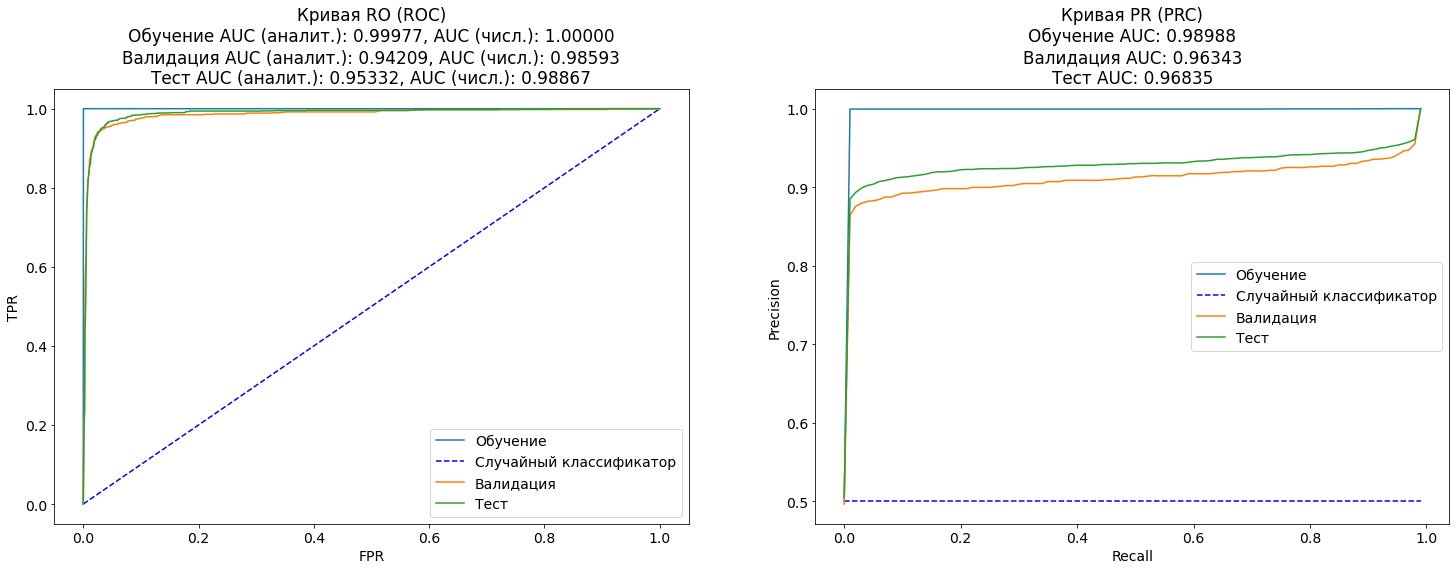

In [23]:
plt.rcParams.update({'font.size': 14})
fig, ax = plt.subplots(1, 2, figsize=(25,8))
ax[0].plot([x / len(metrics_train["ROC"]) for x in range(len(metrics_train["ROC"]))], metrics_train["ROC"], label="Обучение")
ax[0].plot([x / len(metrics_valid["ROC"]) for x in range(len(metrics_valid["ROC"]))], [x / len(metrics_valid["ROC"]) for x in range(len(metrics_valid["ROC"]))], "b--", label="Cлучайный классификатор")
ax[0].plot([x / len(metrics_valid["ROC"]) for x in range(len(metrics_valid["ROC"]))], metrics_valid["ROC"], label="Валидация")
ax[0].plot([x / len(metrics_test["ROC"]) for x in range(len(metrics_test["ROC"]))], metrics_test["ROC"], label="Тест")
ax[0].set_title("Кривая RO (ROC)\nОбучение AUC (аналит.): {:.5f}, AUC (числ.): {:.5f}\nВалидация AUC (аналит.): {:.5f}, AUC (числ.): {:.5f}\nТест AUC (аналит.): {:.5f}, AUC (числ.): {:.5f}".format(
    metrics_train['ROC_AUC_analytic'], metrics_train['ROC_AUC_cycle'], metrics_valid['ROC_AUC_analytic'], metrics_valid['ROC_AUC_cycle'], metrics_test['ROC_AUC_analytic'], metrics_test['ROC_AUC_cycle']
))
ax[0].set_ylabel("TPR")
ax[0].set_xlabel("FPR")
ax[0].legend(loc="best")

ax[1].plot([x / len(metrics_train["PRC"][1]) for x in range(len(metrics_train["PRC"][1]))], metrics_train["PRC"][1], label="Обучение")
ax[1].plot([x / len(metrics_train["PRC"][1]) for x in range(len(metrics_train["PRC"][1]))], [0.5] * len(metrics_train["PRC"][1]), "b--", label="Cлучайный классификатор")
ax[1].plot([x / len(metrics_valid["PRC"][1]) for x in range(len(metrics_valid["PRC"][1]))], metrics_valid["PRC"][1], label="Валидация")
ax[1].plot([x / len(metrics_test["PRC"][1]) for x in range(len(metrics_test["PRC"][1]))], metrics_test["PRC"][1], label="Тест")
ax[1].set_title("Кривая PR (PRC)\nОбучение AUC: {:.5f}\nВалидация AUC: {:.5f}\nТест AUC: {:.5f}".format(metrics_train['PR_AUC'], metrics_valid['PR_AUC'], metrics_test['PR_AUC']))
ax[1].set_ylabel("Precision")
ax[1].set_xlabel("Recall")
ax[1].legend(loc="best")

plt.subplots_adjust(hspace=.7)
plt.show()

In [24]:
print("Результаты на тесте (обощение)")
print("{:17s}: {:10s}".format("метрика", "Значение метрики"))
for i in metrics_test.keys():
    if i != "ROC" and i != "PRC":
        print("{:17s}: {:.4f}".format(i, metrics_test[i]))

Результаты на тесте (обощение)
метрика          : Значение метрики
TP               : 2443.0000
FP               : 54.0000
FN               : 184.0000
TN               : 2262.0000
Recall           : 0.9300
FPR              : 0.0233
FNR              : 0.0700
TNR              : 0.9767
Prevalence       : 0.5315
Accuracy         : 0.9519
Precision        : 0.9784
FDR              : 0.0216
FOR              : 0.0752
NPV              : 0.9248
LR+              : 39.8849
LR-              : 0.0717
DOR              : 556.1661
PT               : 0.1367
TS               : 0.9112
BA               : 0.9533
MCC              : 0.9049
FM               : 0.9539
BM               : 0.9066
MK               : 0.9031
F1               : 0.4768
ROC_AUC_cycle    : 0.9887
ROC_AUC_analytic : 0.9533
PR_AUC           : 0.9684


# Run working models 🧞‍

In [25]:
def predict_pipeline(resnet:keras.Model, model:keras.Model, img_to_predict:np.ndarray, flat_images:np.ndarray, top_metric:int) -> tuple:
    
    flat_img = resnet.predict_proba(img_to_predict.reshape(1,224,224,3))
    temp_array = np.zeros(shape=(len(flat_images), 2 * flat_images.shape[-1]))
    for idx, item in enumerate(flat_images):
        temp_array[idx] = np.hstack([flat_img, item.reshape(1,2048)])
    
    predicts = model.predict_proba(temp_array)
    del temp_array
    predicts = predicts[:, 1]
    top = predicts.argsort()[-top_metric:][::-1]
    
    predicts = (predicts - np.min(predicts)) / (np.max(predicts) - np.min(predicts)) * 100.0
    return top, predicts[top]   

In [26]:
flat_x = np.load("flat_x_wo_aug.npy")
base = pd.read_csv(PATH + "base.csv")

base = pd.read_csv(PATH + "base.csv")
info_id = base.groupby("id").count()
info_id = info_id[info_id["image"] > 2].index
base = base[base['id'].isin(info_id)]
base = base[~base["image"].str.contains("youtube")]

x = []
y = []
for i in range(len(base)):
    x.append(np.array(Image.open(PATH + base.iloc[i, 1] + ".jpg").resize((224,224), Image.ANTIALIAS)))
    y.append(base.iloc[i, 0])

In [35]:
example_image = 1278

In [36]:
%%time
top_ix, predicts_proba = predict_pipeline(resnet, model, x[example_image], flat_x, 5)

2021-04-19 18:51:29 WARNING  Network returning invalid probability values. The last layer might not normalize predictions into probabilities (like softmax or sigmoid would).


(1836, 4096) (2048,) (1, 2048)
Wall time: 400 ms


In [37]:
top_ix

array([1125, 1326,  282,  190,  187], dtype=int64)

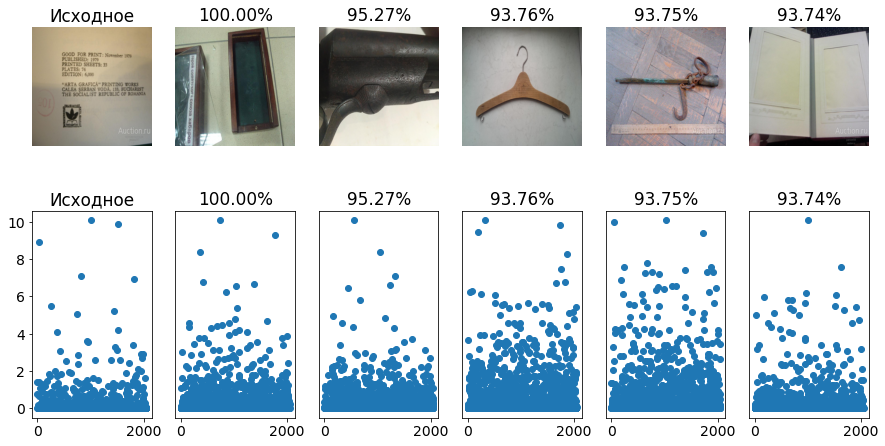

In [38]:
plt.rcParams.update({'font.size':14})
fig, ax = plt.subplots(2, 6, figsize=(15,8))
ax[0,0].imshow(x[example_image])
ax[0,0].set_title("Исходное")
ax[0,0].set_axis_off()
for j, i in enumerate(range(1, 6)):
    ax[0,i].imshow(x[top_ix[j]])
    ax[0,i].set_title("{:.2f}%".format(predicts_proba[j]))
    ax[0,i].set_axis_off()
    
ax[1,0].scatter([x for x in range(flat_x.shape[-1])], flat_x[example_image])
ax[1,0].set_title("Исходное")
for j, i in enumerate(range(1, 6)):
    ax[1,i].scatter([x for x in range(flat_x.shape[-1])], flat_x[top_ix[j]])
    ax[1,i].set_title("{:.2f}%".format(predicts_proba[j]))
    ax[1,i].get_yaxis().set_visible(False)
plt.subplots_adjust(wspace=0.2, hspace=0.1)
plt.show()

## Сохранение для статьи

In [129]:
import pickle

In [131]:
with open('Для_статьи/resnet50_balanced/history.pkl', 'wb') as f:
    pickle.dump(history.history, f)

with open('Для_статьи/resnet50_balanced/metrics_train.pkl', 'wb') as f:
    pickle.dump(metrics_train, f)
    
with open('Для_статьи/resnet50_balanced/metrics_valid.pkl', 'wb') as f:
    pickle.dump(metrics_valid, f)
    
with open('Для_статьи/resnet50_balanced/metrics_test.pkl', 'wb') as f:
    pickle.dump(metrics_test, f)